In [245]:
import random
from pathlib import Path

import numpy as np
import torch
import SimpleITK as sitk
import torchvision
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

import u_net
import utils

# to ensure reproducible training/validation split
random.seed(42)
torch.manual_seed(42)

# directorys with data and to stored training checkpoints
DATA_DIR = Path.cwd().parent.parent / "DevelopmentData"
CHECKPOINTS_DIR = Path.cwd() / "segmentation_model_weights" / f"u_net.pth"

# hyperparameters
NO_VALIDATION_PATIENTS = 2
IMAGE_SIZE = [64, 64]

# find patient folders in training directory
# excluding hidden folders (start with .)
patients = [
    path
    for path in DATA_DIR.glob("*")
    if any(part.startswith("p") for part in path.parts)
]
random.shuffle(patients)

# split in training/validation after shuffling
partition = {
    "train": patients[:-NO_VALIDATION_PATIENTS],
    "validation": patients[-NO_VALIDATION_PATIENTS:],
}

# load validation data
valid_dataset = utils.CombinedProstateMRDataset(partition["validation"], [], IMAGE_SIZE)
total_prostate, total_segment = next(iter(valid_dataset))

unet_model = u_net.UNet(num_classes=1)
unet_model.load_state_dict(torch.load(CHECKPOINTS_DIR))
unet_model.eval()

with torch.no_grad():
    predict_index = 86*2 - 1
    p1 = []
    for i in range(86):
        (img, target) = valid_dataset[i+86]
        output = torch.sigmoid(unet_model(img[np.newaxis, ...]))
        p1.append(output)
    p1 = torch.stack(p1, dim=0).squeeze().squeeze()
    print(p1.shape)
    blur = torchvision.transforms.GaussianBlur(31, sigma=(0.1, 2.0))
    prediction = torch.round(p1)

# dice_scores = []
# for i in range(86):
#     (img, target) = valid_dataset[i+86]
#     dice_scores.append(scipy.spatial.distance.dice(target.view(-1), prediction[i].view(-1)))

dice_scores2 = []
for i in range(86):
    (img, target) = valid_dataset[i+86]
    # flatten label and prediction tensors
    output = prediction[i].view(-1)
    target = target.view(-1)
    # compute Dice
    intersection = (output * target).sum()
    dice = (2.0 * intersection + 1) / (
        output.sum() + target.sum() + 1
    )
    dice_scores2.append(dice)


# plt.subplot(131)
# plt.imshow(img[0], cmap="gray")
# plt.subplot(132)
# plt.imshow(target[0])
# plt.subplot(133)
# plt.imshow(prediction[i])
# plt.show()
    
    # dice_scores = []
    # for (img, target) in valid_dataset:
    #     output = torch.sigmoid(unet_model(img[np.newaxis, ...]))
    #     prediction = torch.round(blur(output))
    #     dice_scores.append(scipy.spatial.distance.dice(target[0].view(-1), prediction[0, 0].view(-1)))

torch.Size([86, 64, 64])


Patient 1 mean: 0.8390, std: 0.2401
Patient 2 mean: 0.5889, std: 0.3354


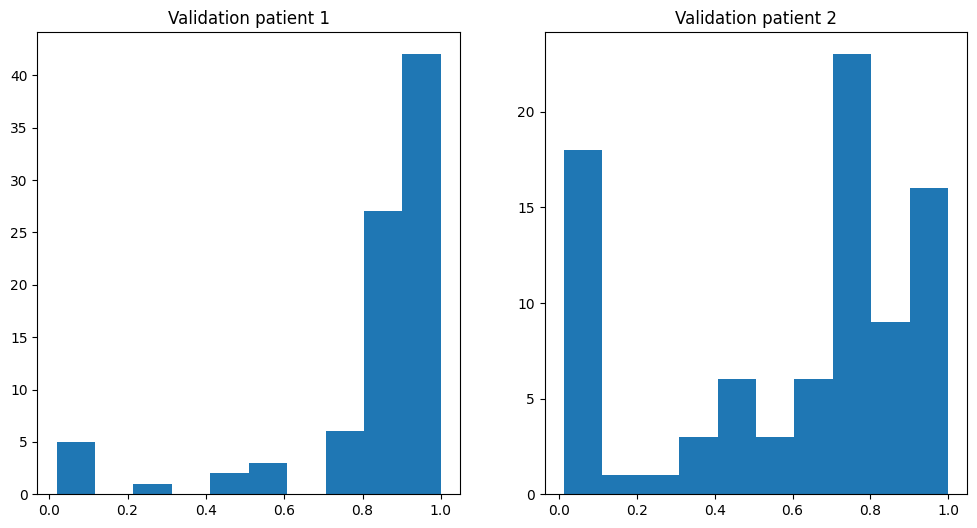

In [292]:
import imp
imp.reload(utils)

def smooth_segmentation(dataloader, model):
    predictions = []
    with torch.no_grad():
        torch.manual_seed(42)
        for (img, _) in dataloader:
            output = torch.sigmoid(model(img[np.newaxis, ...]))
            predictions.append(output)
        full_prostate = torch.stack(predictions, dim=0).squeeze().squeeze()
        blur = torchvision.transforms.GaussianBlur(9, sigma=2)
        smooth_prostate = torch.round(blur(full_prostate))
    return smooth_prostate

def dice_coefficient(output, target):
    intersection = (output * target).sum()
    dice = (2.0 * intersection + 1) / (
        output.sum() + target.sum() + 1
    )
    return dice

p1  = utils.CombinedProstateMRDataset([partition["validation"][0]], [], IMAGE_SIZE, valid=True)
p2  = utils.CombinedProstateMRDataset([partition["validation"][1]], [], IMAGE_SIZE, valid=True)
prediction_p1 = smooth_segmentation(p1, unet_model)
prediction_p2 = smooth_segmentation(p2, unet_model)
dice1 = [dice_coefficient(prediction_p1[i], p1[i][1]) for i in range(len(p1))]
dice2 = [dice_coefficient(prediction_p2[i], p2[i][1]) for i in range(len(p2))]

print(f"Patient 1 mean: {np.mean(dice1):.4f}, std: {np.std(dice1):.4f}")
print(f"Patient 2 mean: {np.mean(dice2):.4f}, std: {np.std(dice2):.4f}")
plt.figure(figsize = (12,6))
plt.subplot(121)
plt.title("Validation patient 1")
plt.hist(dice1)
plt.subplot(122)
plt.title("Validation patient 2")
plt.hist(dice2)
plt.show()

In [ ]:
import torchvision.transforms as transforms

def smooth_segmentation(path, model):
    mr_image = sitk.GetArrayFromImage(sitk.ReadImage(path / "mr_bffe.mhd")).astype(np.int32)
    img_transform = transforms.Compose(
                [
                    transforms.ToPILImage(mode="I"),
                    transforms.CenterCrop(256),
                    transforms.Resize(IMAGE_SIZE),
                    transforms.ToTensor(),
                ]
            )
    data_mean = np.mean(mr_image)
    data_std = np.std(mr_image)
    norm_transform = transforms.Normalize(data_mean, data_std)
    predictions = []
    for slice_n in mr_image:
        seed = np.random.randint(2147483647)  # make a seed with numpy generator
        random.seed(seed)
        torch.manual_seed(seed)
        slice_n = norm_transform(img_transform(slice_n).float())
        with torch.no_grad():
            output = torch.sigmoid(model(slice_n.unsqueeze(0)))
            predictions.append(output)

    full_prostate = torch.stack(predictions, dim=0).squeeze().squeeze()
    blur = torchvision.transforms.GaussianBlur(9, sigma=2)
    smooth_prostate = torch.round(blur(full_prostate))
    return smooth_prostate

def save_predictions(paths, model):
    for path in paths:
        prediction = smooth_segmentation(path, model)
        sitk.WriteImage(sitk.GetImageFromArray(prediction.detach().numpy()), path / "segmentation_prediction.mhd")


DIRECTORY = Path.cwd().parent.parent.parent / "stashed_data" / "ValidataData2" 
data_paths = [
    path
    for path in DIRECTORY.glob("*")
    if path.parts[-1].startswith("p")
]
save_predictions(data_paths, unet_model)


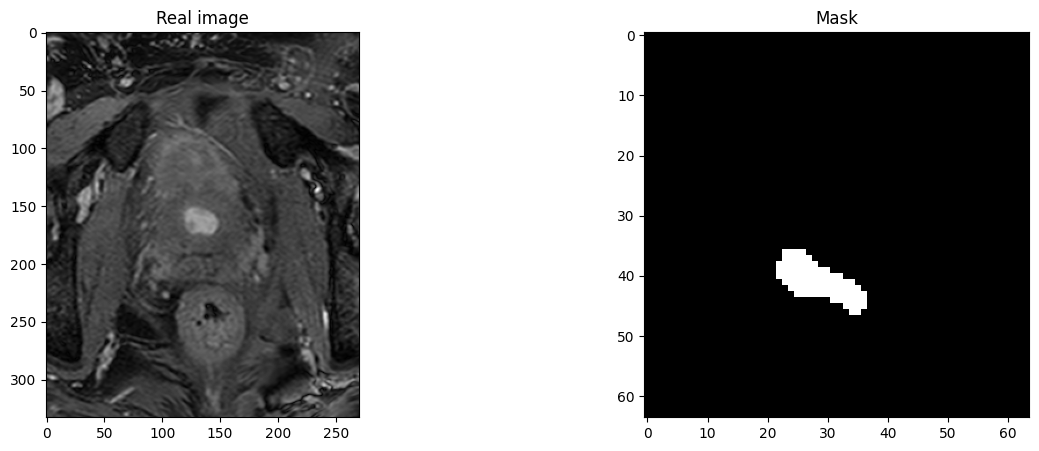

In [ ]:
real_path = r"D:\TUe\8DM20\stashed_data\ValidataData2\p150"
mr = sitk.GetArrayFromImage(sitk.ReadImage(real_path + r"\mr_bffe.mhd"))
segment = sitk.GetArrayFromImage(sitk.ReadImage(real_path + r"\segmentation_prediction.mhd"))
idx = 50
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(mr[idx], cmap="gray")
ax[0].set_title("Real image")
ax[1].imshow(segment[idx], cmap="gray")
ax[1].set_title("Mask");